**Célula S3.0: Configurações, Imports e Caminhos para Sprint 3**

In [1]:
# CÉLULA S3.0: CONFIGURAÇÃO GLOBAL, IMPORTS E MONTAGEM DO DRIVE (FOCO SPRINT 3)

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Imports dos modelos e métricas do Scikit-learn e XGBoost
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import xgboost as xgb # Lembre-se de !pip install xgboost se necessário

# Montar Google Drive (se estiver usando Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive montado com sucesso.")
except ModuleNotFoundError:
    print("AVISO: Não está no ambiente Google Colab ou erro ao montar Drive.")
except Exception as e:
    print(f"Erro ao montar o Google Drive: {e}")

# --- Configurações e Caminhos (AJUSTE TODOS OS CAMINHOS!) ---
# AJUSTE ESTE CAMINHO BASE PARA ONDE ESTÃO SEUS DADOS DA SPRINT 3 NO DRIVE
DRIVE_BASE_PATH_S3 = "/content/drive/MyDrive/Colab Notebooks/FIAP/Fase 7/Atividade - Challenge/data" # Exemplo

if not os.path.isdir(DRIVE_BASE_PATH_S3):
  print(f"AVISO: Diretório base '{DRIVE_BASE_PATH_S3}' não encontrado no Drive. Verifique os caminhos.")

PATH_NDVI_S3_CSV = os.path.join(DRIVE_BASE_PATH_S3, "NDVI.csv")
PATH_EVI_S3_CSV = os.path.join(DRIVE_BASE_PATH_S3, "EVI.csv")
PATH_IBGE_S3_CSV = os.path.join(DRIVE_BASE_PATH_S3, "ibge-dados-cacau.csv")
PATH_WEATHER_CSV = os.path.join(DRIVE_BASE_PATH_S3, "inmet-ilhéus-chuvas-ventos.csv")

# Constantes Globais para Sprint 3
RANDOM_STATE = 42
TEST_YEARS_SPLIT = 10    # Número de anos recentes para teste
N_ESTIMATORS_RF = 100   # Número de árvores para RandomForest e GradientBoosting
MAX_YEAR_IBGE = 2022    # Último ano com dados de produtividade IBGE (conforme seu arquivo)
MIN_YEAR_DATA = 2003    # Ano inicial dos dados meteorológicos (conforme sua inspeção) e, portanto, da análise combinada
VI_THRESHOLD = 0.1      # Threshold para filtrar NDVI/EVI antes da agregação

print("\nConfigurações e imports para Sprint 3 carregados.")
print(f"Caminho base para dados da Sprint 3: {DRIVE_BASE_PATH_S3}")
print(f"Arquivo NDVI: {PATH_NDVI_S3_CSV}")
print(f"Arquivo EVI: {PATH_EVI_S3_CSV}")
print(f"Arquivo IBGE Cacau: {PATH_IBGE_S3_CSV}")
print(f"Arquivo de Clima: {PATH_WEATHER_CSV} (VERIFIQUE ESTE NOME!)")
print(f"Período de análise principal (anos): {MIN_YEAR_DATA} - {MAX_YEAR_IBGE}")

Mounted at /content/drive
Google Drive montado com sucesso.

Configurações e imports para Sprint 3 carregados.
Caminho base para dados da Sprint 3: /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 7/Atividade - Challenge/data
Arquivo NDVI: /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 7/Atividade - Challenge/data/NDVI.csv
Arquivo EVI: /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 7/Atividade - Challenge/data/EVI.csv
Arquivo IBGE Cacau: /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 7/Atividade - Challenge/data/ibge-dados-cacau.csv
Arquivo de Clima: /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 7/Atividade - Challenge/data/inmet-ilhéus-chuvas-ventos.csv (VERIFIQUE ESTE NOME!)
Período de análise principal (anos): 2003 - 2022


**Célula S3.1: Carregar e Pré-processar Dados NDVI, EVI e IBGE**

In [2]:
# CÉLULA S3.1: CARREGAR DADOS BRUTOS DA SPRINT 3

df_ndvi_s3_raw, df_evi_s3_raw, df_ibge_s3_raw, df_weather_raw = None, None, None, None # Inicializa

print(f"--- Carregando: {PATH_NDVI_S3_CSV} ---")
try:
    df_ndvi_s3_raw = pd.read_csv(PATH_NDVI_S3_CSV, sep=None, engine='python', encoding='latin-1')
    print(f"'{PATH_NDVI_S3_CSV}' carregado. Shape: {df_ndvi_s3_raw.shape}")
except Exception as e: print(f"Erro ao carregar '{PATH_NDVI_S3_CSV}': {e}")

print(f"\n--- Carregando: {PATH_EVI_S3_CSV} ---")
try:
    df_evi_s3_raw = pd.read_csv(PATH_EVI_S3_CSV, sep=None, engine='python', encoding='latin-1')
    print(f"'{PATH_EVI_S3_CSV}' carregado. Shape: {df_evi_s3_raw.shape}")
except Exception as e: print(f"Erro ao carregar '{PATH_EVI_S3_CSV}': {e}")

print(f"\n--- Carregando: {PATH_IBGE_S3_CSV} ---")
try:
    df_ibge_s3_raw = pd.read_csv(PATH_IBGE_S3_CSV, sep=None, engine='python', encoding='latin-1')
    print(f"'{PATH_IBGE_S3_CSV}' carregado. Shape: {df_ibge_s3_raw.shape}")
except Exception as e: print(f"Erro ao carregar '{PATH_IBGE_S3_CSV}': {e}")

print(f"\n--- Carregando: {PATH_WEATHER_CSV} ---")
try:
    df_weather_raw = pd.read_csv(PATH_WEATHER_CSV, sep=None, engine='python', encoding='latin-1', header='infer') # header='infer' tenta adivinhar
    # Se for o arquivo INMET padrão, pode precisar de skiprows=8 e sep=';', decimal=','
    # Ex: pd.read_csv(PATH_WEATHER_CSV, sep=';', decimal=',', skiprows=8, encoding='latin-1')
    print(f"'{PATH_WEATHER_CSV}' carregado. Shape: {df_weather_raw.shape}")
    print("\nInfo df_weather_raw:")
    df_weather_raw.info()
    print("\nHead df_weather_raw:")
    print(df_weather_raw.head())
except Exception as e:
    print(f"Erro ao carregar '{PATH_WEATHER_CSV}': {e}. VERIFIQUE O CAMINHO E O FORMATO DO ARQUIVO.")

print("\n--- Carregamento inicial dos dados da Sprint 3 concluído (ou tentado). ---")

--- Carregando: /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 7/Atividade - Challenge/data/NDVI.csv ---
'/content/drive/MyDrive/Colab Notebooks/FIAP/Fase 7/Atividade - Challenge/data/NDVI.csv' carregado. Shape: (1102, 3)

--- Carregando: /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 7/Atividade - Challenge/data/EVI.csv ---
'/content/drive/MyDrive/Colab Notebooks/FIAP/Fase 7/Atividade - Challenge/data/EVI.csv' carregado. Shape: (1102, 3)

--- Carregando: /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 7/Atividade - Challenge/data/ibge-dados-cacau.csv ---
'/content/drive/MyDrive/Colab Notebooks/FIAP/Fase 7/Atividade - Challenge/data/ibge-dados-cacau.csv' carregado. Shape: (49, 11)

--- Carregando: /content/drive/MyDrive/Colab Notebooks/FIAP/Fase 7/Atividade - Challenge/data/inmet-ilhéus-chuvas-ventos.csv ---
'/content/drive/MyDrive/Colab Notebooks/FIAP/Fase 7/Atividade - Challenge/data/inmet-ilhéus-chuvas-ventos.csv' carregado. Shape: (190800, 22)

Info df_weather_raw:
<class 'p

**Célula S3.2: Agregar NDVI/EVI Anual e Unir com Dados do IBGE\**

In [3]:
# CÉLULA S3.2: PRÉ-PROCESSAR DADOS DE NDVI e EVI

df_ndvi_processed, df_evi_processed = None, None # Inicializa

def process_vi_dataframe_s3(df, vi_col_name, max_year, min_year):
    if df is None or df.empty:
        print(f"DataFrame para {vi_col_name} não carregado ou vazio. Pulando processamento.")
        return None
    print(f"\n--- Processando DataFrame: {vi_col_name} ---")
    if 'Data' not in df.columns or vi_col_name not in df.columns:
        print(f"Erro: Colunas 'Data' ou '{vi_col_name}' não encontradas.")
        return None

    df_proc = df[['Data', vi_col_name]].copy()
    try:
        df_proc['Data'] = pd.to_datetime(df_proc['Data'], format='%d/%m/%Y', errors='coerce')
    except ValueError: # Tentar inferir se o formato específico falhar
        print(f"Formato dd/mm/yyyy falhou para {vi_col_name}, tentando inferir...")
        df_proc['Data'] = pd.to_datetime(df_proc['Data'], errors='coerce')
    df_proc.dropna(subset=['Data'], inplace=True)

    if df_proc[vi_col_name].dtype == 'object':
        df_proc[vi_col_name] = df_proc[vi_col_name].str.replace(',', '.', regex=False).astype(float, errors='ignore')
    df_proc[vi_col_name] = pd.to_numeric(df_proc[vi_col_name], errors='coerce')
    df_proc.dropna(subset=[vi_col_name], inplace=True)

    df_proc['Ano'] = df_proc['Data'].dt.year
    df_proc['Mes'] = df_proc['Data'].dt.month
    df_proc = df_proc[(df_proc['Ano'] <= max_year) & (df_proc['Ano'] >= min_year)].copy()
    print(f"DataFrame {vi_col_name} processado. Shape: {df_proc.shape}")
    return df_proc

if 'df_ndvi_s3_raw' in locals():
    df_ndvi_processed = process_vi_dataframe_s3(df_ndvi_s3_raw, 'NDVI', MAX_YEAR_IBGE, MIN_YEAR_DATA)
if 'df_evi_s3_raw' in locals():
    df_evi_processed = process_vi_dataframe_s3(df_evi_s3_raw, 'EVI', MAX_YEAR_IBGE, MIN_YEAR_DATA)

if df_ndvi_processed is not None: print(df_ndvi_processed.head(2))
if df_evi_processed is not None: print(df_evi_processed.head(2))


--- Processando DataFrame: NDVI ---
DataFrame NDVI processado. Shape: (920, 4)

--- Processando DataFrame: EVI ---
DataFrame EVI processado. Shape: (920, 4)
         Data    NDVI   Ano  Mes
78 2003-01-01  0.8866  2003    1
79 2003-01-09  0.8194  2003    1
         Data     EVI   Ano  Mes
78 2003-01-01  0.4441  2003    1
79 2003-01-09  0.5909  2003    1


**Célula S3.3: Adicionar Features Lagged e Limpeza Final**

In [4]:
# CÉLULA S3.3: PRÉ-PROCESSAR DADOS DO IBGE (CACAU)

df_ibge_processed = None # Inicializa

if 'df_ibge_s3_raw' in locals() and df_ibge_s3_raw is not None and not df_ibge_s3_raw.empty:
    print("\n--- Processando DataFrame: IBGE Cacau ---")
    cols_to_keep_ibge = {
        'ano': 'Ano', 'id_municipio_nome': 'Municipio', 'produto': 'Produto',
        'area_colhida': 'Area_Colhida_ha_Real',
        'rendimento_medio_producao': 'Produtividade_Real_kg_ha',
        'quantidade_produzida': 'Qtde_Produzida_Ton_Real'
    }
    if all(col in df_ibge_s3_raw.columns for col in cols_to_keep_ibge.keys()):
        df_ibge_processed = df_ibge_s3_raw[list(cols_to_keep_ibge.keys())].copy()
        df_ibge_processed.rename(columns=cols_to_keep_ibge, inplace=True)
        df_ibge_processed['Municipio'] = df_ibge_processed['Municipio'].str.replace('IlhÃ©us', 'Ilhéus', regex=False)
        df_ibge_processed['Produto'] = df_ibge_processed['Produto'].str.replace('Cacau (em amÃªndoa)', 'Cacau (em amêndoa)', regex=False)
        df_ibge_processed = df_ibge_processed[
            (df_ibge_processed['Municipio'] == 'Ilhéus') &
            (df_ibge_processed['Produto'] == 'Cacau (em amêndoa)')
        ].copy()
        final_ibge_cols = ['Ano', 'Produtividade_Real_kg_ha', 'Area_Colhida_ha_Real', 'Qtde_Produzida_Ton_Real']
        df_ibge_processed = df_ibge_processed[final_ibge_cols]
        df_ibge_processed = df_ibge_processed[(df_ibge_processed['Ano'] >= MIN_YEAR_DATA) & (df_ibge_processed['Ano'] <= MAX_YEAR_IBGE)].copy()
        print(f"DataFrame IBGE processado e filtrado. Shape: {df_ibge_processed.shape}")
        print(df_ibge_processed.head(2))
    else:
        print("Erro: Colunas esperadas não encontradas no df_ibge_s3_raw.")
else:
    print("DataFrame df_ibge_s3_raw está vazio ou não foi carregado. Pulando processamento.")


--- Processando DataFrame: IBGE Cacau ---
DataFrame IBGE processado e filtrado. Shape: (20, 4)
     Ano  Produtividade_Real_kg_ha  Area_Colhida_ha_Real  \
29  2003                     160.0                 12000   
30  2004                     150.0                 53790   

    Qtde_Produzida_Ton_Real  
29                   1920.0  
30                   8069.0  


**Célula S3.4: Análise de Correlação e Regressão Linear Simples (VI vs. Produtividade Real)**

In [5]:
# CÉLULA S3.4: PRÉ-PROCESSAR DADOS METEOROLÓGICOS (HORÁRIO PARA DIÁRIO) (CORRIGIDO)

df_weather_daily_agg = None # Inicializa

if 'df_weather_raw' in locals() and df_weather_raw is not None and not df_weather_raw.empty:
    print(f"\n--- Pré-processando Dados Meteorológicos (Original shape: {df_weather_raw.shape}) ---")
    df_weather = df_weather_raw.copy()
    try:
        # Tentativa mais robusta de criar Timestamp, comum para dados INMET
        if 'data' in df_weather.columns and 'hora' in df_weather.columns:
            df_weather['Timestamp'] = pd.to_datetime(df_weather['data'] + ' ' + df_weather['hora'].str.replace(' UTC', '', regex=False).str.replace('BD', '', regex=False), errors='coerce')
        elif 'Data' in df_weather.columns and 'Hora' in df_weather.columns: # Nomes alternativos comuns
             df_weather['Timestamp'] = pd.to_datetime(df_weather['Data'] + ' ' + df_weather['Hora'].str.replace(' UTC', '', regex=False).str.replace('BD', '', regex=False), errors='coerce')
        else:
            raise ValueError("Colunas 'data'/'hora' ou 'Data'/'Hora' não encontradas para criar Timestamp.")

        df_weather.dropna(subset=['Timestamp'], inplace=True)
        df_weather.set_index('Timestamp', inplace=True)
        print(f"Coluna 'Timestamp' criada e definida como índice. Registros: {len(df_weather)}")
    except Exception as e:
        print(f"Erro ao criar Timestamp: {e}"); df_weather = None

    if df_weather is not None:
        cols_original_weather = {
            'precipitacao_total': 'precip_raw',
            'temperatura_max': 'temp_max_raw', # Pode ser max do dia anterior em dados convencionais
            'temperatura_min': 'temp_min_raw', # Pode ser min do dia anterior
            'temperatura_bulbo_hora': 'temp_bulbo_raw', # Boa proxy para temperatura horária
            'umidade_rel_hora': 'umid_rel_raw',
            'radiacao_global': 'rad_global_raw'
        }
        # Garantir que estamos usando apenas colunas que realmente existem no df_weather
        actual_cols_to_select = [col for col in cols_original_weather.keys() if col in df_weather.columns]

        if not actual_cols_to_select:
            print("Erro: Nenhuma das colunas meteorológicas esperadas foi encontrada no arquivo original.")
            df_weather_selected = None
        else:
            df_weather_selected = df_weather[actual_cols_to_select].copy()
            # Renomeia apenas as colunas que foram efetivamente selecionadas
            df_weather_selected.rename(columns={k: cols_original_weather[k] for k in actual_cols_to_select}, inplace=True)
            print(f"Colunas meteorológicas selecionadas/renomeadas: {list(df_weather_selected.columns)}")

        if df_weather_selected is not None and not df_weather_selected.empty:
            # Tratamento Inicial de NaNs (Horário)
            if 'precip_raw' in df_weather_selected.columns:
                df_weather_selected['precip_raw'] = df_weather_selected['precip_raw'].fillna(0)
            if 'rad_global_raw' in df_weather_selected.columns:
                df_weather_selected['rad_global_raw'] = df_weather_selected['rad_global_raw'].fillna(0)
                # Assegura que radiação não seja negativa
                df_weather_selected.loc[df_weather_selected['rad_global_raw'] < 0, 'rad_global_raw'] = 0

            if isinstance(df_weather_selected.index, pd.DatetimeIndex):
                aggs_daily = {}
                # Construir o dicionário de agregação dinamicamente
                if 'precip_raw' in df_weather_selected.columns:
                    aggs_daily['chuva_total_diaria_mm'] = pd.NamedAgg(column='precip_raw', aggfunc='sum')
                if 'temp_bulbo_raw' in df_weather_selected.columns: # Usaremos esta como base para temp max, min e media
                    aggs_daily['temp_max_diaria_C'] = pd.NamedAgg(column='temp_bulbo_raw', aggfunc='max')
                    aggs_daily['temp_min_diaria_C'] = pd.NamedAgg(column='temp_bulbo_raw', aggfunc='min')
                    aggs_daily['temp_media_diaria_C'] = pd.NamedAgg(column='temp_bulbo_raw', aggfunc='mean')
                if 'umid_rel_raw' in df_weather_selected.columns:
                    aggs_daily['umidade_media_diaria_perc'] = pd.NamedAgg(column='umid_rel_raw', aggfunc='mean')
                if 'rad_global_raw' in df_weather_selected.columns:
                    aggs_daily['radiacao_total_diaria_kJ_m2'] = pd.NamedAgg(column='rad_global_raw', aggfunc='sum')

                if aggs_daily: # Verifica se há algo para agregar
                    df_weather_daily_agg = df_weather_selected.resample('D').agg(**aggs_daily)
                    df_weather_daily_agg.dropna(axis=1, how='all', inplace=True) # Remove colunas que ficaram só com NaN
                    print(f"\nDados meteorológicos agregados para diário. Shape: {df_weather_daily_agg.shape}")

                    df_weather_daily_agg['Ano'] = df_weather_daily_agg.index.year
                    df_weather_daily_agg['Mes'] = df_weather_daily_agg.index.month
                    df_weather_daily_agg['Dia'] = df_weather_daily_agg.index.day

                    cols_fill = [c for c in df_weather_daily_agg.columns if c not in ['Ano','Mes','Dia']]
                    df_weather_daily_agg[cols_fill] = df_weather_daily_agg[cols_fill].ffill()
                    df_weather_daily_agg[cols_fill] = df_weather_daily_agg[cols_fill].bfill()
                    print("NaNs nos dados diários preenchidos com ffill e bfill.")

                    df_weather_daily_agg = df_weather_daily_agg[
                        (df_weather_daily_agg['Ano'] >= MIN_YEAR_DATA) & # MIN_YEAR_DATA da Célula S3.0
                        (df_weather_daily_agg['Ano'] <= MAX_YEAR_IBGE)   # MAX_YEAR_IBGE da Célula S3.0
                    ].copy()
                    print(f"Dados diários filtrados ({MIN_YEAR_DATA}-{MAX_YEAR_IBGE}). Shape final: {df_weather_daily_agg.shape}")

                    print("\n--- Head do df_weather_daily_agg ---")
                    print(df_weather_daily_agg.head())
                    print("\n--- Info do df_weather_daily_agg ---")
                    df_weather_daily_agg.info()
                    print("\n--- NaNs restantes no df_weather_daily_agg ---")
                    print(df_weather_daily_agg.isnull().sum())
                else:
                    print("Nenhuma agregação diária pôde ser definida (colunas de origem ausentes?).") # Corrigido
                    df_weather_daily_agg = None
            else:
                print("Erro: Índice do DataFrame meteorológico não é DatetimeIndex. Agregação diária não pode ser feita.")
                df_weather_daily_agg = None
        else:
            print("Erro: df_weather_selected não pôde ser criado ou ficou vazio. Verifique as colunas no arquivo original.")
            df_weather_daily_agg = None # Define como None se df_weather_selected for None
else:
    print("\n--- Pré-processamento de dados meteorológicos pulado: df_weather_raw não disponível ou vazio. ---")


--- Pré-processando Dados Meteorológicos (Original shape: (190800, 22)) ---
Coluna 'Timestamp' criada e definida como índice. Registros: 190800
Colunas meteorológicas selecionadas/renomeadas: ['precip_raw', 'temp_max_raw', 'temp_min_raw', 'temp_bulbo_raw', 'umid_rel_raw', 'rad_global_raw']

Dados meteorológicos agregados para diário. Shape: (7950, 6)
NaNs nos dados diários preenchidos com ffill e bfill.
Dados diários filtrados (2003-2022). Shape final: (7281, 9)

--- Head do df_weather_daily_agg ---
            chuva_total_diaria_mm  temp_max_diaria_C  temp_min_diaria_C  \
Timestamp                                                                 
2003-01-25                    0.0               30.5               20.8   
2003-01-26                    0.4               29.6               22.0   
2003-01-27                    5.6               28.5               21.6   
2003-01-28                   16.2               31.0               22.3   
2003-01-29                    1.8           

**Célula S3.5: Preparar X, y e Dividir Treino/Teste para Modelos Complexos**

In [6]:
# CÉLULA S3.5: AGREGAR FEATURES CLIMÁTICAS ANUAIS

df_weather_annual_features = None # Inicializa

if 'df_weather_daily_agg' in locals() and df_weather_daily_agg is not None and not df_weather_daily_agg.empty:
    print(f"\n--- Agregando Features Climáticas Diárias para Anual (Shape diário: {df_weather_daily_agg.shape}) ---")
    annual_agg_funcs_weather = {}
    if 'chuva_total_diaria_mm' in df_weather_daily_agg.columns: annual_agg_funcs_weather['precip_total_anual_mm'] = pd.NamedAgg(column='chuva_total_diaria_mm', aggfunc='sum')
    if 'temp_max_diaria_C' in df_weather_daily_agg.columns: annual_agg_funcs_weather['temp_max_media_anual_C'] = pd.NamedAgg(column='temp_max_diaria_C', aggfunc='mean')
    if 'temp_min_diaria_C' in df_weather_daily_agg.columns: annual_agg_funcs_weather['temp_min_media_anual_C'] = pd.NamedAgg(column='temp_min_diaria_C', aggfunc='mean')
    if 'temp_media_diaria_C' in df_weather_daily_agg.columns: annual_agg_funcs_weather['temp_media_anual_C'] = pd.NamedAgg(column='temp_media_diaria_C', aggfunc='mean')
    if 'umidade_media_diaria_perc' in df_weather_daily_agg.columns: annual_agg_funcs_weather['umidade_media_anual_perc'] = pd.NamedAgg(column='umidade_media_diaria_perc', aggfunc='mean')
    if 'radiacao_total_diaria_kJ_m2' in df_weather_daily_agg.columns: annual_agg_funcs_weather['radiacao_total_anual_kJ_m2'] = pd.NamedAgg(column='radiacao_total_diaria_kJ_m2', aggfunc='sum')

    if 'chuva_total_diaria_mm' in df_weather_daily_agg.columns:
         dias_com_chuva = df_weather_daily_agg[df_weather_daily_agg['chuva_total_diaria_mm'] > 1].groupby('Ano').size().rename('dias_com_chuva_gt_1mm_anual')

    if annual_agg_funcs_weather:
        df_weather_annual_features = df_weather_daily_agg.groupby('Ano').agg(**annual_agg_funcs_weather).reset_index()
        if 'dias_com_chuva' in locals() and not dias_com_chuva.empty:
            df_weather_annual_features = pd.merge(df_weather_annual_features, dias_com_chuva, on='Ano', how='left')
            if 'dias_com_chuva_gt_1mm_anual' in df_weather_annual_features.columns:
                 df_weather_annual_features['dias_com_chuva_gt_1mm_anual'] = df_weather_annual_features['dias_com_chuva_gt_1mm_anual'].fillna(0)
        print(f"Features climáticas anuais agregadas. Shape: {df_weather_annual_features.shape}")
        # print(df_weather_annual_features.head(2)); df_weather_annual_features.info() # Debug prints
    else: print("Nenhuma agregação anual de clima definida."); df_weather_annual_features = None
else:
    print("\n--- Agregação de features climáticas anuais pulada: df_weather_daily_agg não disponível ou vazio. ---")


--- Agregando Features Climáticas Diárias para Anual (Shape diário: (7281, 9)) ---
Features climáticas anuais agregadas. Shape: (20, 8)


**Célula S3.6: Treinar Múltiplos Modelos de Previsão de Rendimento**

In [7]:
# CÉLULA S3.6: AGREGAR VI ANUAL, MERGE FINAL (IBGE, VI, CLIMA) E ADICIONAR LAGS

df_sprint3_model_input = None # Inicializa

if 'df_ibge_processed' in locals() and df_ibge_processed is not None and not df_ibge_processed.empty and \
   'df_ndvi_processed' in locals() and df_ndvi_processed is not None and \
   'df_evi_processed' in locals() and df_evi_processed is not None:

    print("\n--- Agregando Estatísticas Anuais de NDVI (Sprint 3) ---")
    df_ndvi_filtered_s3_agg = df_ndvi_processed[df_ndvi_processed['NDVI'] > VI_THRESHOLD]
    if not df_ndvi_filtered_s3_agg.empty:
        df_ndvi_anual_s3_agg = df_ndvi_filtered_s3_agg.groupby('Ano')['NDVI'].agg(
            ndvi_medio_anual='mean', ndvi_max_anual='max', ndvi_min_anual='min',
            ndvi_std_anual='std', ndvi_count_anual='count'
        ).reset_index()
        df_ndvi_anual_s3_agg['ndvi_std_anual'] = df_ndvi_anual_s3_agg['ndvi_std_anual'].fillna(0)
    else: df_ndvi_anual_s3_agg = pd.DataFrame(columns=['Ano'])
    # print("NDVI Anual Agregado (Sprint 3) head:", df_ndvi_anual_s3_agg.head(2)) # Debug

    print("\n--- Agregando Estatísticas Anuais de EVI (Sprint 3) ---")
    df_evi_filtered_s3_agg = df_evi_processed[df_evi_processed['EVI'] > VI_THRESHOLD]
    if not df_evi_filtered_s3_agg.empty:
        df_evi_anual_s3_agg = df_evi_filtered_s3_agg.groupby('Ano')['EVI'].agg(
            evi_medio_anual='mean', evi_max_anual='max', evi_min_anual='min',
            evi_std_anual='std', evi_count_anual='count'
        ).reset_index()
        df_evi_anual_s3_agg['evi_std_anual'] = df_evi_anual_s3_agg['evi_std_anual'].fillna(0)
    else: df_evi_anual_s3_agg = pd.DataFrame(columns=['Ano'])
    # print("EVI Anual Agregado (Sprint 3) head:", df_evi_anual_s3_agg.head(2)) # Debug

    print("\n--- Unindo Todos os Dados Processados (IBGE, VI, Clima) ---")
    df_merged_all_s3 = df_ibge_processed.copy()
    df_merged_all_s3 = pd.merge(df_merged_all_s3, df_ndvi_anual_s3_agg, on='Ano', how='left')
    df_merged_all_s3 = pd.merge(df_merged_all_s3, df_evi_anual_s3_agg, on='Ano', how='left')
    if 'df_weather_annual_features' in locals() and df_weather_annual_features is not None and not df_weather_annual_features.empty:
        df_merged_all_s3 = pd.merge(df_merged_all_s3, df_weather_annual_features, on='Ano', how='left')
        print("Merge com features climáticas anuais realizado.")
    else:
        print("Aviso: Features climáticas anuais não disponíveis para merge. Verifique a Célula S3.5.")
    # print("Shape após todos os merges:", df_merged_all_s3.shape) # Debug

    print("\n--- Adicionando Features Lagged ---")
    df_merged_all_s3['Produtividade_Real_kg_ha_lag1'] = df_merged_all_s3['Produtividade_Real_kg_ha'].shift(1)
    df_merged_all_s3['Area_Colhida_ha_Real_lag1'] = df_merged_all_s3['Area_Colhida_ha_Real'].shift(1)

    print("Removendo linhas com NaNs (introduzidos por lags ou merges)...")
    rows_before_final_drop = len(df_merged_all_s3)
    df_sprint3_model_input = df_merged_all_s3.dropna().reset_index(drop=True)
    rows_after_final_drop = len(df_sprint3_model_input)
    print(f"Linhas removidas: {rows_before_final_drop - rows_after_final_drop}")

    print(f"\nDataFrame final para modelagem (df_sprint3_model_input) pronto. Shape: {df_sprint3_model_input.shape}")
    if not df_sprint3_model_input.empty:
         print(f"Cobertura Anual: {df_sprint3_model_input['Ano'].min()}-{df_sprint3_model_input['Ano'].max()}")
         print("\nHead do df_sprint3_model_input:")
         print(df_sprint3_model_input.head())
         print("\nInfo do df_sprint3_model_input:")
         df_sprint3_model_input.info()
         print("\nNaNs restantes no df_sprint3_model_input:")
         print(df_sprint3_model_input.isnull().sum())
    else:
        print("AVISO: df_sprint3_model_input ficou VAZIO após limpeza final!")
else:
    print("Erro: Um ou mais DataFrames de entrada (IBGE, NDVI, EVI) não estão disponíveis. Pipeline interrompido.")


--- Agregando Estatísticas Anuais de NDVI (Sprint 3) ---

--- Agregando Estatísticas Anuais de EVI (Sprint 3) ---

--- Unindo Todos os Dados Processados (IBGE, VI, Clima) ---
Merge com features climáticas anuais realizado.

--- Adicionando Features Lagged ---
Removendo linhas com NaNs (introduzidos por lags ou merges)...
Linhas removidas: 1

DataFrame final para modelagem (df_sprint3_model_input) pronto. Shape: (19, 23)
Cobertura Anual: 2004-2022

Head do df_sprint3_model_input:
    Ano  Produtividade_Real_kg_ha  Area_Colhida_ha_Real  \
0  2004                     150.0                 53790   
1  2005                     180.0                 49746   
2  2006                     185.0                 49237   
3  2007                     198.0                 50430   
4  2008                     192.0                 51354   

   Qtde_Produzida_Ton_Real  ndvi_medio_anual  ndvi_max_anual  ndvi_min_anual  \
0                   8069.0          0.830870          0.9296          0.2702   


**Célula S3.7: Avaliar e Visualizar Modelos de Rendimento**


--- Análise Estatística (Etapa 3) usando dados de 2004-2022 ---

--- Correlação: Produtividade_Real_kg_ha vs ndvi_medio_anual ---
Correlação de Pearson (ndvi_medio_anual): -0.3494 (p-value: 0.1426)
Correlação de Spearman (ndvi_medio_anual): -0.2766 (p-value: 0.2517)

--- Correlação: Produtividade_Real_kg_ha vs evi_medio_anual ---
Correlação de Pearson (evi_medio_anual): -0.4630 (p-value: 0.0459)
Correlação de Spearman (evi_medio_anual): -0.4205 (p-value: 0.0730)

Regressão Linear: Produtividade_Real_kg_ha ~ ndvi_medio_anual
  Equação: Produtividade_Real_kg_ha = -533.30 * ndvi_medio_anual + 652.88
  Coeficiente de Determinação (R²): 0.1221

Regressão Linear: Produtividade_Real_kg_ha ~ evi_medio_anual
  Equação: Produtividade_Real_kg_ha = -691.92 * evi_medio_anual + 595.34
  Coeficiente de Determinação (R²): 0.2144


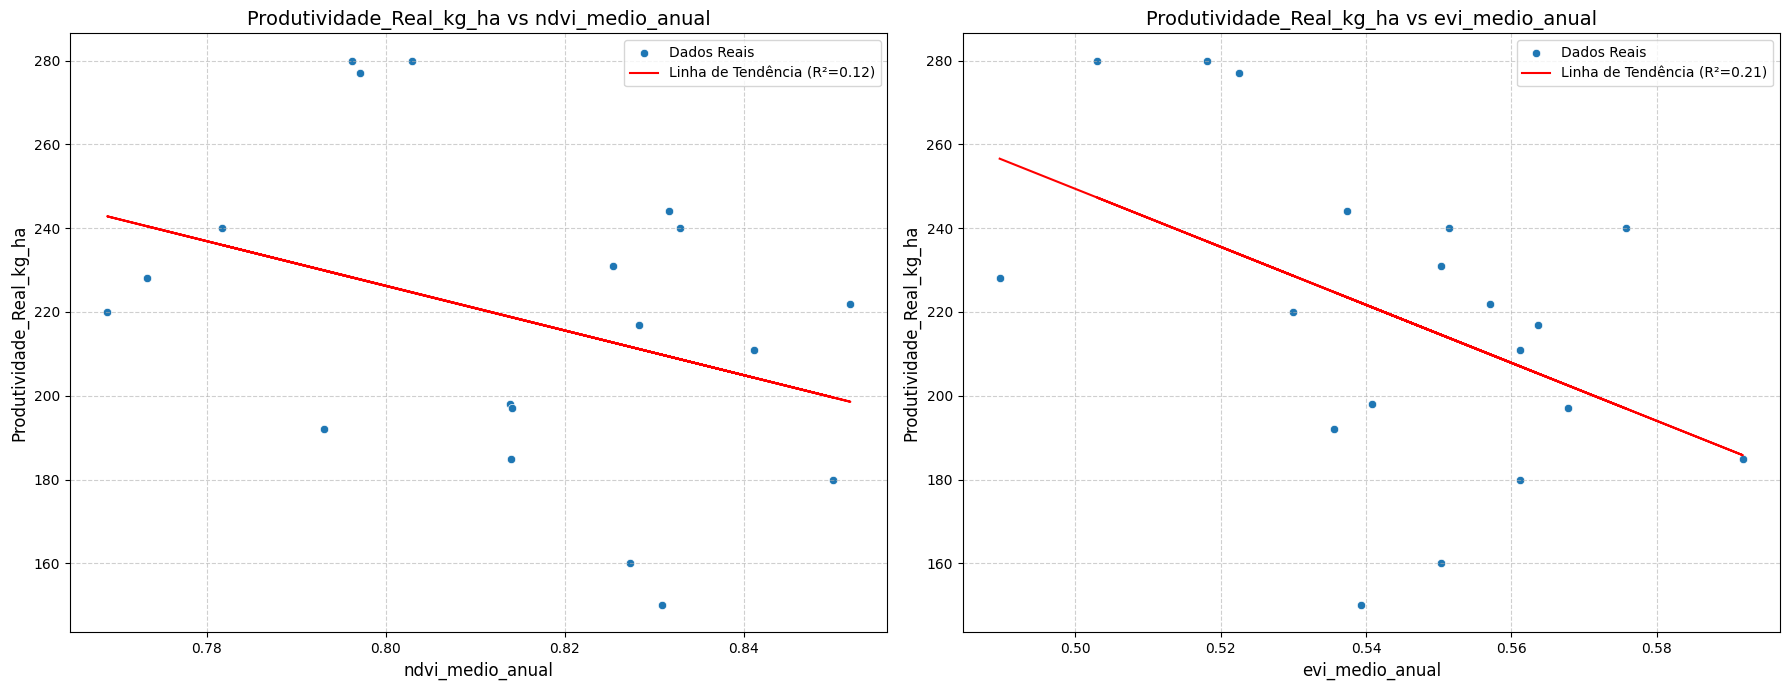

In [8]:
# CÉLULA S3.7: ANÁLISE DE CORRELAÇÃO E REGRESSÃO LINEAR SIMPLES

# Pré-requisito: df_sprint3_model_input da célula anterior
if 'df_sprint3_model_input' in locals() and df_sprint3_model_input is not None and not df_sprint3_model_input.empty:
    print(f"\n--- Análise Estatística (Etapa 3) usando dados de {df_sprint3_model_input['Ano'].min()}-{df_sprint3_model_input['Ano'].max()} ---")
    target_col_s3_corr = 'Produtividade_Real_kg_ha'
    ndvi_col_s3_corr = 'ndvi_medio_anual'
    evi_col_s3_corr = 'evi_medio_anual'

    # Verificar se as colunas de VI existem (podem ter sido removidas se o merge não encontrou dados)
    cols_to_check_corr = [target_col_s3_corr]
    if ndvi_col_s3_corr in df_sprint3_model_input.columns: cols_to_check_corr.append(ndvi_col_s3_corr)
    if evi_col_s3_corr in df_sprint3_model_input.columns: cols_to_check_corr.append(evi_col_s3_corr)

    if not all(col in df_sprint3_model_input.columns for col in cols_to_check_corr):
        print(f"Erro: Uma ou mais colunas para correlação não encontradas no DataFrame.")
    else:
        if ndvi_col_s3_corr in df_sprint3_model_input.columns:
            print(f"\n--- Correlação: {target_col_s3_corr} vs {ndvi_col_s3_corr} ---")
            pearson_ndvi, p_value_pearson_ndvi = pearsonr(df_sprint3_model_input[target_col_s3_corr], df_sprint3_model_input[ndvi_col_s3_corr])
            spearman_ndvi, p_value_spearman_ndvi = spearmanr(df_sprint3_model_input[target_col_s3_corr], df_sprint3_model_input[ndvi_col_s3_corr])
            print(f"Correlação de Pearson ({ndvi_col_s3_corr}): {pearson_ndvi:.4f} (p-value: {p_value_pearson_ndvi:.4f})")
            print(f"Correlação de Spearman ({ndvi_col_s3_corr}): {spearman_ndvi:.4f} (p-value: {p_value_spearman_ndvi:.4f})")
        else: print(f"Aviso: Coluna {ndvi_col_s3_corr} não encontrada para correlação.")

        if evi_col_s3_corr in df_sprint3_model_input.columns:
            print(f"\n--- Correlação: {target_col_s3_corr} vs {evi_col_s3_corr} ---")
            pearson_evi, p_value_pearson_evi = pearsonr(df_sprint3_model_input[target_col_s3_corr], df_sprint3_model_input[evi_col_s3_corr])
            spearman_evi, p_value_spearman_evi = spearmanr(df_sprint3_model_input[target_col_s3_corr], df_sprint3_model_input[evi_col_s3_corr])
            print(f"Correlação de Pearson ({evi_col_s3_corr}): {pearson_evi:.4f} (p-value: {p_value_pearson_evi:.4f})")
            print(f"Correlação de Spearman ({evi_col_s3_corr}): {spearman_evi:.4f} (p-value: {p_value_spearman_evi:.4f})")
        else: print(f"Aviso: Coluna {evi_col_s3_corr} não encontrada para correlação.")

        def analyze_linear_regression_s3(df, x_col, y_col, ax):
            X_reg = df[[x_col]]
            y_reg = df[y_col]
            model = LinearRegression().fit(X_reg, y_reg)
            y_pred_reg = model.predict(X_reg)
            r2 = r2_score(y_reg, y_pred_reg)
            print(f"\nRegressão Linear: {y_col} ~ {x_col}")
            print(f"  Equação: {y_col} = {model.coef_[0]:.2f} * {x_col} + {model.intercept_:.2f}")
            print(f"  Coeficiente de Determinação (R²): {r2:.4f}")
            sns.scatterplot(x=x_col, y=y_col, data=df, ax=ax, label='Dados Reais')
            ax.plot(df[x_col], y_pred_reg, color='red', label=f'Linha de Tendência (R²={r2:.2f})')
            ax.set_title(f'{y_col} vs {x_col}', fontsize=14); ax.set_xlabel(x_col, fontsize=12)
            ax.set_ylabel(y_col, fontsize=12); ax.legend(); ax.grid(True, linestyle='--', alpha=0.6)

        num_plots = 0
        if ndvi_col_s3_corr in df_sprint3_model_input.columns: num_plots +=1
        if evi_col_s3_corr in df_sprint3_model_input.columns: num_plots +=1

        if num_plots > 0:
            fig, axes = plt.subplots(1, num_plots, figsize=(9*num_plots, 7), squeeze=False) # squeeze=False para garantir que axes é sempre 2D
            plot_idx = 0
            if ndvi_col_s3_corr in df_sprint3_model_input.columns:
                analyze_linear_regression_s3(df_sprint3_model_input, ndvi_col_s3_corr, target_col_s3_corr, axes[0, plot_idx])
                plot_idx += 1
            if evi_col_s3_corr in df_sprint3_model_input.columns:
                 analyze_linear_regression_s3(df_sprint3_model_input, evi_col_s3_corr, target_col_s3_corr, axes[0, plot_idx])
            plt.tight_layout(); plt.show()
        else:
            print("Nenhuma coluna de VI para plotar regressão linear simples.")
else:
    print("Erro: df_sprint3_model_input não encontrado ou vazio. Análise estatística pulada.")

**Célula S3.8: Importância das Features (Modelos da Sprint 3)**

In [9]:
# CÉLULA S3.8: PREPARAR X, y E DIVIDIR TREINO/TESTE PARA MODELOS COMPLEXOS

# Pré-requisito: df_sprint3_model_input da célula anterior
# TEST_YEARS_SPLIT e RANDOM_STATE devem estar definidos (Célula S3.0)

# Inicializar variáveis para evitar NameError se o if principal falhar
X_train_s3, X_test_s3, y_train_s3, y_test_s3, anos_test_s3, features_s3_list = None, None, None, None, None, None

if 'df_sprint3_model_input' in locals() and isinstance(df_sprint3_model_input, pd.DataFrame) and not df_sprint3_model_input.empty:
    print(f"\n--- Preparando X, y e Dividindo Treino/Teste usando df_sprint3_model_input (Shape: {df_sprint3_model_input.shape}) ---")
    print(f"DEBUG: Usando TEST_YEARS_SPLIT = {TEST_YEARS_SPLIT}")

    target_s3_model = 'Produtividade_Real_kg_ha'
    # Excluir também Qtde_Produzida_Ton_Real se ainda estiver presente por algum motivo
    features_to_exclude_model = [target_s3_model, 'Ano', 'Qtde_Produzida_Ton_Real']
    features_s3_list = [col for col in df_sprint3_model_input.columns if col not in features_to_exclude_model]

    if target_s3_model in df_sprint3_model_input.columns and all(f in df_sprint3_model_input.columns for f in features_s3_list):
        X_s3_model = df_sprint3_model_input[features_s3_list]
        y_s3_model = df_sprint3_model_input[target_s3_model]
        print(f"Features (X_s3_model) selecionadas: {features_s3_list}")
        print(f"Shape de X_s3_model: {X_s3_model.shape}, Shape de y_s3_model: {y_s3_model.shape}")

        split_index_s3_model = len(X_s3_model) - TEST_YEARS_SPLIT
        print(f"Índice de divisão para modelagem: {split_index_s3_model} (Total Linhas: {len(X_s3_model)}, Anos Teste: {TEST_YEARS_SPLIT})")

        if split_index_s3_model > 0 and TEST_YEARS_SPLIT > 0 and split_index_s3_model < len(X_s3_model):
            X_train_s3, X_test_s3 = X_s3_model.iloc[:split_index_s3_model], X_s3_model.iloc[split_index_s3_model:]
            y_train_s3, y_test_s3 = y_s3_model.iloc[:split_index_s3_model], y_s3_model.iloc[split_index_s3_model:]
            anos_s3_all = df_sprint3_model_input['Ano'].tolist() # Usar o DF correto para os anos
            anos_train_s3 = anos_s3_all[:split_index_s3_model]
            anos_test_s3 = anos_s3_all[split_index_s3_model:]
            print(f"Shape de X_train_s3: {X_train_s3.shape}, Shape de y_train_s3: {y_train_s3.shape}")
            print(f"Shape de X_test_s3: {X_test_s3.shape}, Shape de y_test_s3: {y_test_s3.shape}")
            if anos_train_s3 and anos_test_s3:
                 print(f"Divisão Temporal: Treino ({min(anos_train_s3)}-{max(anos_train_s3)}), Teste ({min(anos_test_s3)}-{max(anos_test_s3)})")
            print("Variáveis de treino/teste (X_train_s3, etc.) criadas com sucesso.")
        else:
            print(f"Erro: Dados insuficientes ({len(X_s3_model)} linhas) ou TEST_YEARS_SPLIT ({TEST_YEARS_SPLIT}) inválido.")
    else:
        print(f"Erro: Coluna target '{target_s3_model}' ou alguma feature em {features_s3_list} não encontrada.")
else:
    print("\n--- Preparação X/y/Split para modelos complexos pulada: df_sprint3_model_input não disponível ou vazio. ---")


--- Preparando X, y e Dividindo Treino/Teste usando df_sprint3_model_input (Shape: (19, 23)) ---
DEBUG: Usando TEST_YEARS_SPLIT = 10
Features (X_s3_model) selecionadas: ['Area_Colhida_ha_Real', 'ndvi_medio_anual', 'ndvi_max_anual', 'ndvi_min_anual', 'ndvi_std_anual', 'ndvi_count_anual', 'evi_medio_anual', 'evi_max_anual', 'evi_min_anual', 'evi_std_anual', 'evi_count_anual', 'precip_total_anual_mm', 'temp_max_media_anual_C', 'temp_min_media_anual_C', 'temp_media_anual_C', 'umidade_media_anual_perc', 'radiacao_total_anual_kJ_m2', 'dias_com_chuva_gt_1mm_anual', 'Produtividade_Real_kg_ha_lag1', 'Area_Colhida_ha_Real_lag1']
Shape de X_s3_model: (19, 20), Shape de y_s3_model: (19,)
Índice de divisão para modelagem: 9 (Total Linhas: 19, Anos Teste: 10)
Shape de X_train_s3: (9, 20), Shape de y_train_s3: (9,)
Shape de X_test_s3: (10, 20), Shape de y_test_s3: (10,)
Divisão Temporal: Treino (2004-2012), Teste (2013-2022)
Variáveis de treino/teste (X_train_s3, etc.) criadas com sucesso.


In [10]:
# CÉLULA S3.9: TREINAR MÚLTIPLOS MODELOS COMPLEXOS

# Pré-requisito: X_train_s3, y_train_s3 da célula anterior
# N_ESTIMATORS_RF e RANDOM_STATE devem estar definidos (Célula S3.0)
trained_models_s3 = None # Inicializa

if 'X_train_s3' in locals() and X_train_s3 is not None and 'y_train_s3' in locals() and y_train_s3 is not None:
    print("\n--- Treinando Múltiplos Modelos Complexos (Sprint 3) ---")
    models_to_train_s3 = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(random_state=RANDOM_STATE),
        "Decision Tree": DecisionTreeRegressor(random_state=RANDOM_STATE),
        "SVR": SVR(),
        "Random Forest": RandomForestRegressor(n_estimators=N_ESTIMATORS_RF, random_state=RANDOM_STATE, n_jobs=-1),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=N_ESTIMATORS_RF, random_state=RANDOM_STATE),
        "XGBoost": xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, objective='reg:squarederror')
    }
    trained_models_s3 = {}
    for name, model_instance in models_to_train_s3.items(): # Usar model_instance para não sobrescrever 'model' se usado em escopo maior
        print(f"--- Treinando Modelo: {name} ---")
        current_model = model_instance # Evitar modificar o dicionário original se set_params for usado
        start_train_time = time.time()
        try:
            current_model.fit(X_train_s3, y_train_s3)
            trained_models_s3[name] = current_model
            train_time = time.time() - start_train_time
            print(f"Treinamento concluído em {train_time:.2f} segundos.")
        except Exception as e:
            print(f"Erro ao treinar o modelo {name}: {e}")
    if trained_models_s3:
        print(f"\n--- Todos os modelos complexos foram treinados: {list(trained_models_s3.keys())} ---")
    else:
        print("\nNenhum modelo complexo foi treinado com sucesso.")
else:
    print("\n--- Treinamento de modelos complexos (Sprint 3) pulado: Dados de treino não disponíveis. ---")


--- Treinando Múltiplos Modelos Complexos (Sprint 3) ---
--- Treinando Modelo: Linear Regression ---
Treinamento concluído em 0.01 segundos.
--- Treinando Modelo: Ridge Regression ---
Treinamento concluído em 0.00 segundos.
--- Treinando Modelo: Decision Tree ---
Treinamento concluído em 0.00 segundos.
--- Treinando Modelo: SVR ---
Treinamento concluído em 0.00 segundos.
--- Treinando Modelo: Random Forest ---
Treinamento concluído em 0.18 segundos.
--- Treinando Modelo: Gradient Boosting ---
Treinamento concluído em 0.07 segundos.
--- Treinando Modelo: XGBoost ---
Treinamento concluído em 0.07 segundos.

--- Todos os modelos complexos foram treinados: ['Linear Regression', 'Ridge Regression', 'Decision Tree', 'SVR', 'Random Forest', 'Gradient Boosting', 'XGBoost'] ---



--- Avaliando Modelos Complexos Treinados (Sprint 3) no Conjunto de Teste ---
--- Avaliando: Linear Regression ---
  RMSE: 61.0179
  MAE:  42.9709
  R²:   -2.5479
  (Atenção: R² negativo indica desempenho ruim no teste)
--- Avaliando: Ridge Regression ---
  RMSE: 58.4311
  MAE:  41.3204
  R²:   -2.2535
  (Atenção: R² negativo indica desempenho ruim no teste)
--- Avaliando: Decision Tree ---
  RMSE: 39.6787
  MAE:  29.8000
  R²:   -0.5003
  (Atenção: R² negativo indica desempenho ruim no teste)
--- Avaliando: SVR ---
  RMSE: 45.4877
  MAE:  39.3514
  R²:   -0.9717
  (Atenção: R² negativo indica desempenho ruim no teste)
--- Avaliando: Random Forest ---
  RMSE: 28.9221
  MAE:  21.7380
  R²:   0.2029
--- Avaliando: Gradient Boosting ---
  RMSE: 27.3212
  MAE:  22.4336
  R²:   0.2887
--- Avaliando: XGBoost ---
  RMSE: 45.1335
  MAE:  39.0284
  R²:   -0.9411
  (Atenção: R² negativo indica desempenho ruim no teste)

--- Comparativo de Resultados dos Modelos Complexos (Sprint 3) ---
        

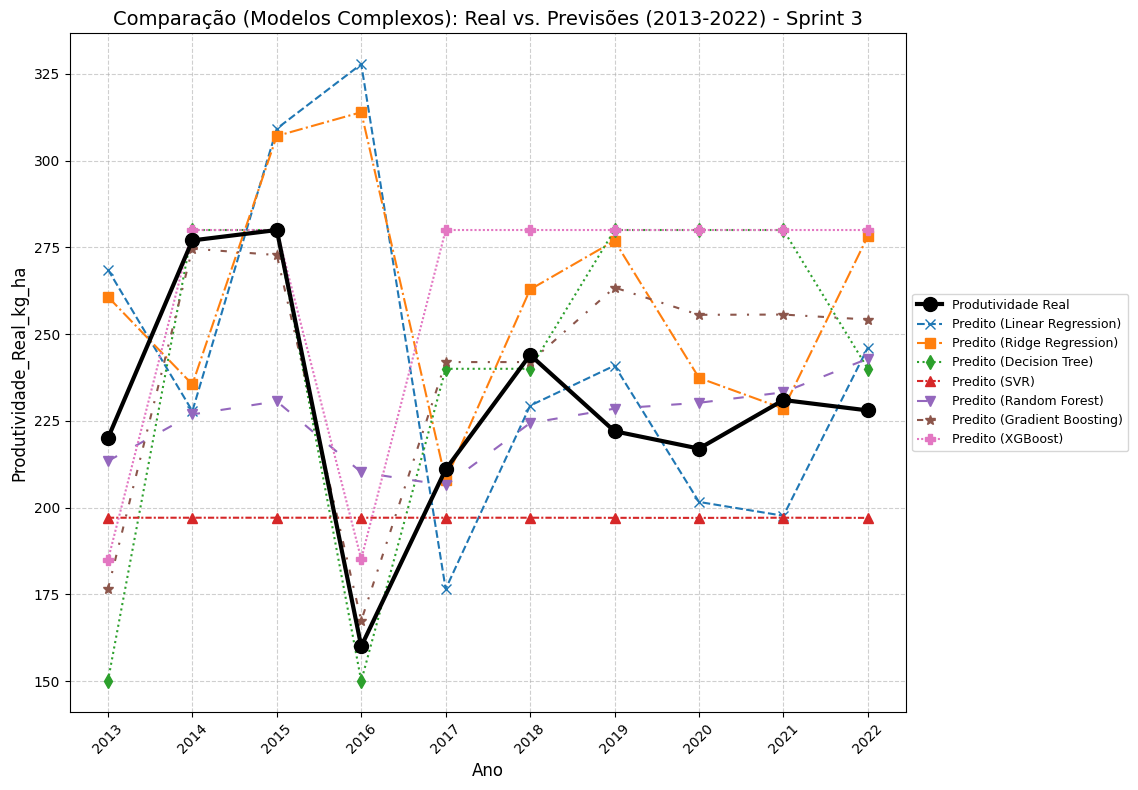

In [11]:
# CÉLULA S3.10: AVALIAR E VISUALIZAR MODELOS COMPLEXOS

# Pré-requisito: trained_models_s3, X_test_s3, y_test_s3, anos_test_s3 da célula anterior

results_s3_metrics = {} # Renomeado para evitar conflito se 'results' existir de outra célula
predictions_s3_values = {} # Renomeado

if 'trained_models_s3' in locals() and trained_models_s3 is not None and \
   'X_test_s3' in locals() and X_test_s3 is not None and \
   'y_test_s3' in locals() and y_test_s3 is not None and \
   'anos_test_s3' in locals() and anos_test_s3 is not None:

    print("\n--- Avaliando Modelos Complexos Treinados (Sprint 3) no Conjunto de Teste ---")
    for name, model in trained_models_s3.items():
        print(f"--- Avaliando: {name} ---")
        try:
            y_pred_s3_current = model.predict(X_test_s3)
            predictions_s3_values[name] = y_pred_s3_current
            rmse = np.sqrt(mean_squared_error(y_test_s3, y_pred_s3_current))
            mae = mean_absolute_error(y_test_s3, y_pred_s3_current)
            r2 = r2_score(y_test_s3, y_pred_s3_current)
            results_s3_metrics[name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
            print(f"  RMSE: {rmse:.4f}"); print(f"  MAE:  {mae:.4f}"); print(f"  R²:   {r2:.4f}")
            if r2 < 0: print("  (Atenção: R² negativo indica desempenho ruim no teste)")
        except Exception as e:
            print(f"Erro ao avaliar o modelo {name}: {e}")
            results_s3_metrics[name] = {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan}

    if results_s3_metrics:
        print("\n--- Comparativo de Resultados dos Modelos Complexos (Sprint 3) ---")
        results_df_s3_final = pd.DataFrame(results_s3_metrics).T
        print(results_df_s3_final.sort_values(by='R2', ascending=False))
    else:
        print("Nenhum resultado de modelo para comparar.")

    if predictions_s3_values:
        print("\n--- Gerando Gráfico Comparativo Previsto vs Real (Sprint 3 - Modelos Complexos) ---")
        plt.figure(figsize=(14, 8))
        plt.plot(anos_test_s3, y_test_s3, label='Produtividade Real', marker='o', linewidth=3, markersize=10, color='black', zorder=10)
        linestyles = ['--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 10)), (0, (3, 5, 1, 5)), (0, (1, 1))]
        style_idx = 0; markers = ['x', 's', 'd', '^', 'v', '*', 'P']
        for name, y_pred_values in predictions_s3_values.items():
            if y_pred_values is not None:
                style = linestyles[style_idx % len(linestyles)]; marker = markers[style_idx % len(markers)]
                plt.plot(anos_test_s3, y_pred_values, label=f'Predito ({name})', marker=marker, linestyle=style, markersize=7)
                style_idx += 1
        plt.xlabel('Ano', fontsize=12)
        target_col_name_plot = y_test_s3.name if hasattr(y_test_s3, 'name') else 'Produtividade_Real_kg_ha'
        plt.ylabel(f'{target_col_name_plot}', fontsize=12)
        if anos_test_s3:
             plt.title(f'Comparação (Modelos Complexos): Real vs. Previsões ({min(anos_test_s3)}-{max(anos_test_s3)}) - Sprint 3', fontsize=14)
        else: plt.title(f'Comparação (Modelos Complexos): Real vs. Previsões - Sprint 3', fontsize=14)
        plt.legend(fontsize=9, loc='center left', bbox_to_anchor=(1, 0.5)); plt.grid(True, linestyle='--', alpha=0.6)
        if anos_test_s3: plt.xticks(anos_test_s3, rotation=45)
        plt.tight_layout(rect=[0, 0, 0.82, 1]); plt.show()
    else:
        print("Nenhuma previsão disponível para plotar.")
else:
    print("\n--- Avaliação/Visualização de Modelos Complexos (Sprint 3) pulada. ---")


--- Análise de Importância/Coeficientes das Features (Sprint 3 - Modelos Complexos) ---

--- Modelo: Linear Regression ---
Coeficientes:
                          Feature   Coefficient
5                ndvi_count_anual -4.627242e+00
13         temp_min_media_anual_C -3.862590e+00
15       umidade_media_anual_perc -3.548656e+00
14             temp_media_anual_C -3.319892e+00
12         temp_max_media_anual_C -2.950978e+00
18  Produtividade_Real_kg_ha_lag1  1.088895e+00
17    dias_com_chuva_gt_1mm_anual  9.835426e-01
3                  ndvi_min_anual  6.211419e-01
7                   evi_max_anual -5.869181e-01
8                   evi_min_anual -5.334873e-01
6                 evi_medio_anual -3.324734e-01
2                  ndvi_max_anual  3.000662e-01
10                evi_count_anual -2.289354e-01
11          precip_total_anual_mm -9.317316e-02
4                  ndvi_std_anual -6.251385e-02
9                   evi_std_anual  3.545916e-02
1                ndvi_medio_anual -4.474891e-0

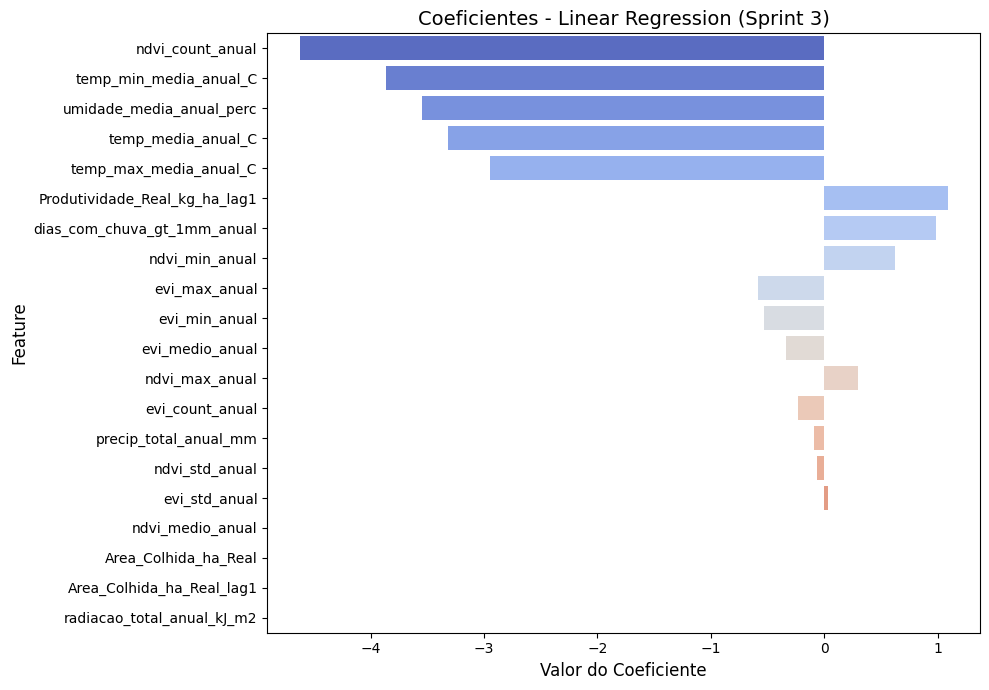


--- Modelo: Ridge Regression ---
Coeficientes:
                          Feature   Coefficient
15       umidade_media_anual_perc -2.586888e+00
5                ndvi_count_anual -2.581484e+00
13         temp_min_media_anual_C -2.247575e+00
14             temp_media_anual_C -1.809357e+00
12         temp_max_media_anual_C -1.435981e+00
18  Produtividade_Real_kg_ha_lag1  9.787440e-01
17    dias_com_chuva_gt_1mm_anual  9.660546e-01
3                  ndvi_min_anual  3.562496e-01
7                   evi_max_anual -3.480657e-01
8                   evi_min_anual -3.009723e-01
6                 evi_medio_anual -1.911765e-01
2                  ndvi_max_anual  1.698529e-01
11          precip_total_anual_mm -9.089685e-02
10                evi_count_anual -8.567775e-02
4                  ndvi_std_anual -3.402594e-02
9                   evi_std_anual  1.832877e-02
1                ndvi_medio_anual -2.310561e-03
0            Area_Colhida_ha_Real -1.617439e-03
19      Area_Colhida_ha_Real_lag1  7.068

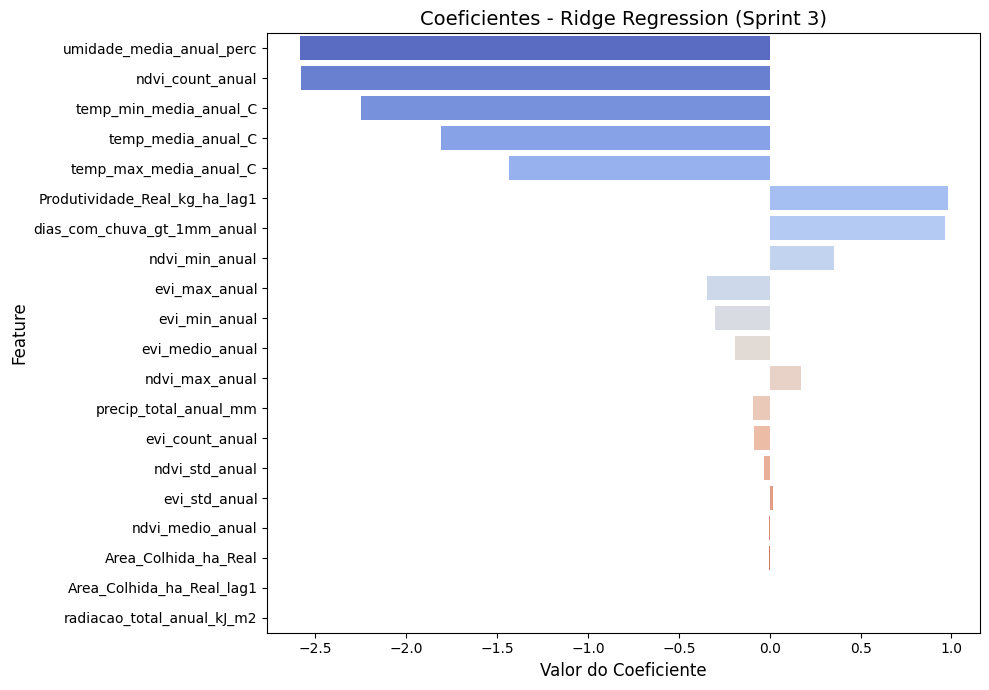


--- Modelo: Decision Tree ---
Importância das Features:
                          Feature  Importance
0            Area_Colhida_ha_Real    0.784402
12         temp_max_media_anual_C    0.109911
14             temp_media_anual_C    0.086196
18  Produtividade_Real_kg_ha_lag1    0.016811
15       umidade_media_anual_perc    0.001630
10                evi_count_anual    0.001010
11          precip_total_anual_mm    0.000040
1                ndvi_medio_anual    0.000000
3                  ndvi_min_anual    0.000000
2                  ndvi_max_anual    0.000000
4                  ndvi_std_anual    0.000000
5                ndvi_count_anual    0.000000
8                   evi_min_anual    0.000000
9                   evi_std_anual    0.000000
6                 evi_medio_anual    0.000000
7                   evi_max_anual    0.000000
13         temp_min_media_anual_C    0.000000
16     radiacao_total_anual_kJ_m2    0.000000
17    dias_com_chuva_gt_1mm_anual    0.000000
19      Area_Colhida_ha

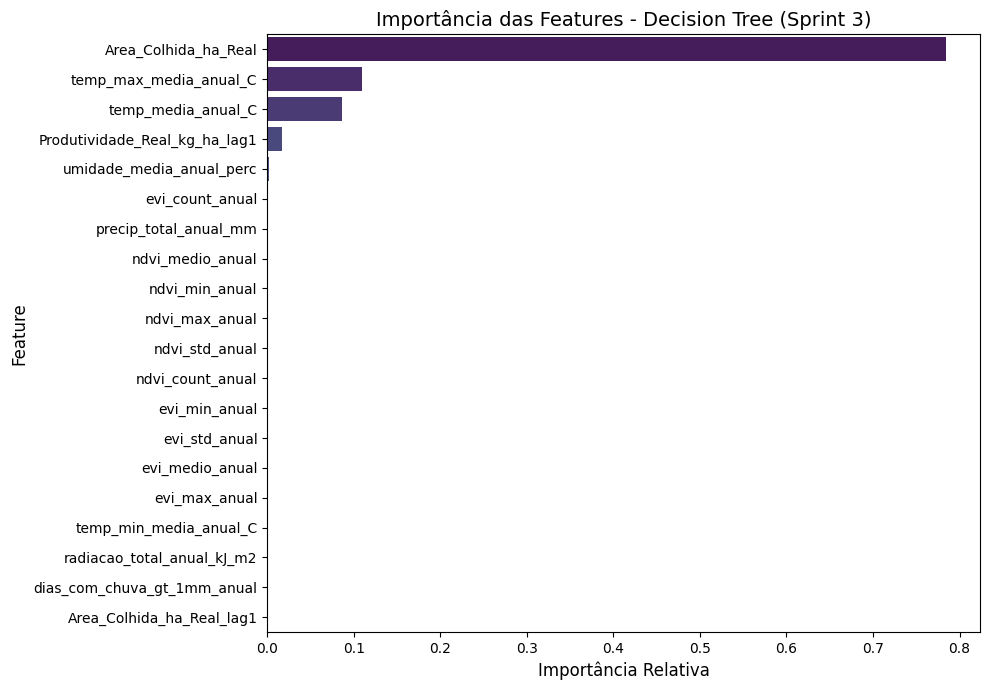


--- Modelo: SVR ---
Modelo não possui '.feature_importances_' ou '.coef_'.

--- Modelo: Random Forest ---
Importância das Features:
                          Feature  Importance
0            Area_Colhida_ha_Real    0.233686
18  Produtividade_Real_kg_ha_lag1    0.134477
19      Area_Colhida_ha_Real_lag1    0.132604
12         temp_max_media_anual_C    0.109313
5                ndvi_count_anual    0.074097
10                evi_count_anual    0.051297
14             temp_media_anual_C    0.034082
9                   evi_std_anual    0.032343
1                ndvi_medio_anual    0.028631
15       umidade_media_anual_perc    0.023807
6                 evi_medio_anual    0.020762
7                   evi_max_anual    0.017835
13         temp_min_media_anual_C    0.017541
3                  ndvi_min_anual    0.016495
16     radiacao_total_anual_kJ_m2    0.015560
2                  ndvi_max_anual    0.014934
4                  ndvi_std_anual    0.014716
17    dias_com_chuva_gt_1mm_anual    0.

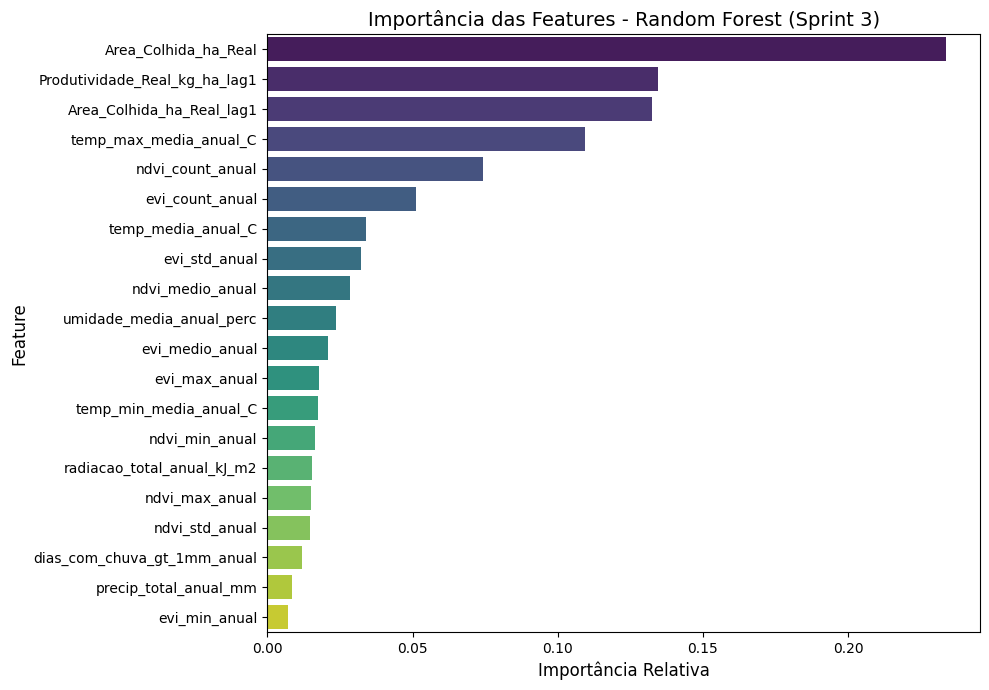


--- Modelo: Gradient Boosting ---
Importância das Features:
                          Feature  Importance
0            Area_Colhida_ha_Real    0.790771
12         temp_max_media_anual_C    0.043360
14             temp_media_anual_C    0.032998
9                   evi_std_anual    0.031377
17    dias_com_chuva_gt_1mm_anual    0.022117
7                   evi_max_anual    0.015258
15       umidade_media_anual_perc    0.014980
6                 evi_medio_anual    0.011260
8                   evi_min_anual    0.009513
18  Produtividade_Real_kg_ha_lag1    0.007114
13         temp_min_media_anual_C    0.007104
11          precip_total_anual_mm    0.003775
19      Area_Colhida_ha_Real_lag1    0.003423
16     radiacao_total_anual_kJ_m2    0.003209
5                ndvi_count_anual    0.001229
3                  ndvi_min_anual    0.001184
2                  ndvi_max_anual    0.000883
4                  ndvi_std_anual    0.000337
10                evi_count_anual    0.000103
1                nd

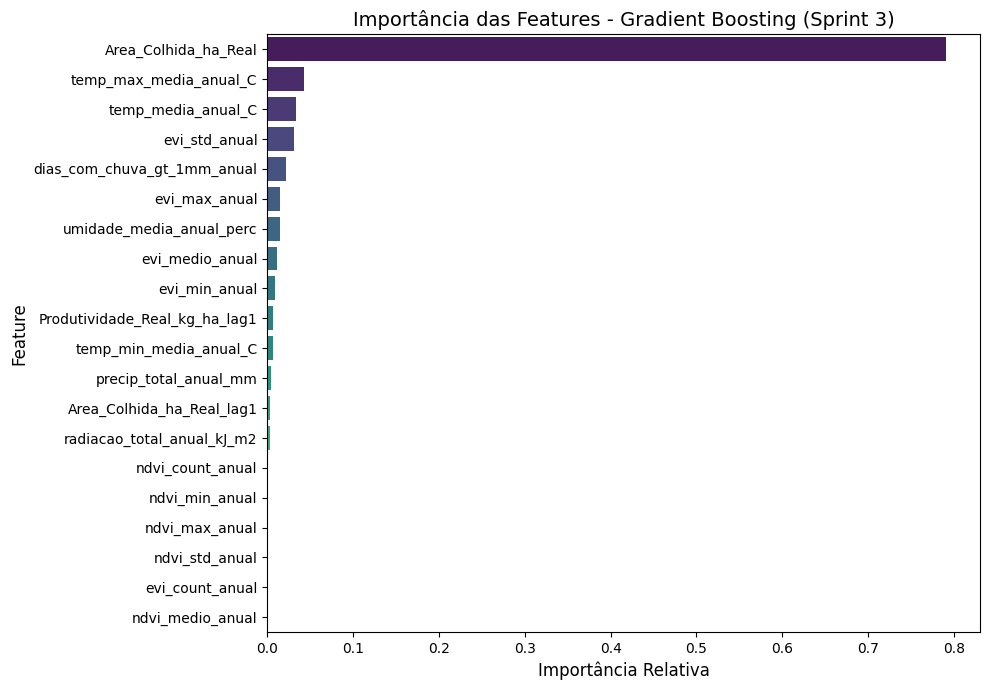


--- Modelo: XGBoost ---
Importância das Features:
                          Feature    Importance
0            Area_Colhida_ha_Real  6.793911e-01
11          precip_total_anual_mm  2.259711e-01
1                ndvi_medio_anual  8.587880e-02
7                   evi_max_anual  8.455641e-03
5                ndvi_count_anual  2.697296e-04
16     radiacao_total_anual_kJ_m2  2.169781e-05
3                  ndvi_min_anual  1.199519e-05
4                  ndvi_std_anual  4.651618e-08
9                   evi_std_anual  2.029940e-08
2                  ndvi_max_anual  0.000000e+00
8                   evi_min_anual  0.000000e+00
6                 evi_medio_anual  0.000000e+00
10                evi_count_anual  0.000000e+00
12         temp_max_media_anual_C  0.000000e+00
14             temp_media_anual_C  0.000000e+00
13         temp_min_media_anual_C  0.000000e+00
15       umidade_media_anual_perc  0.000000e+00
17    dias_com_chuva_gt_1mm_anual  0.000000e+00
18  Produtividade_Real_kg_ha_lag1  0.

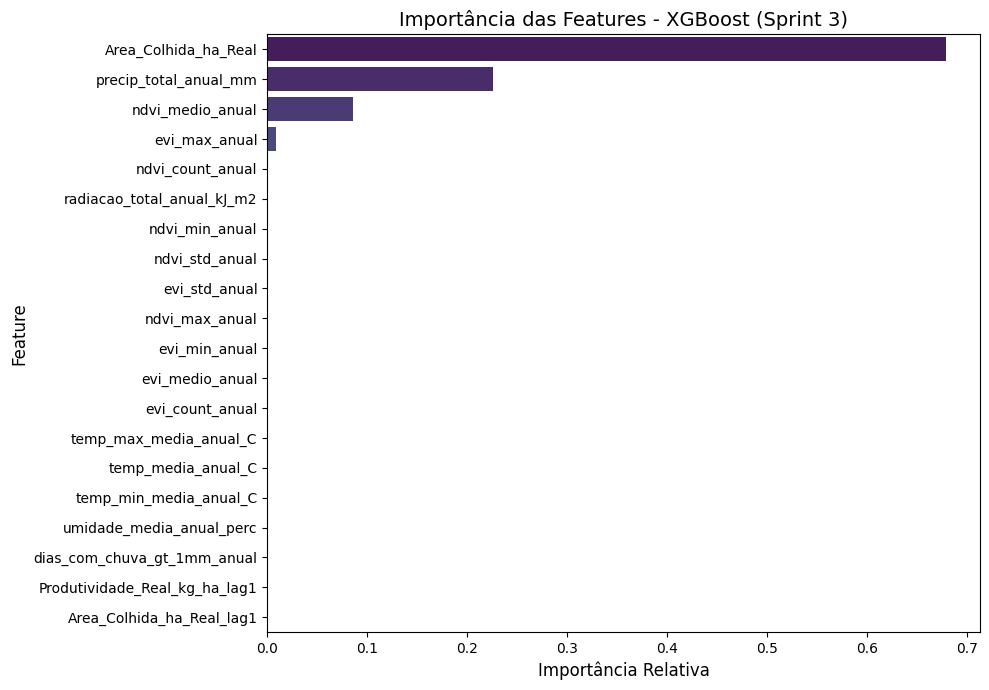



--- FLUXO PRINCIPAL DA SPRINT 3 CONCLUÍDO ---
A próxima etapa seria a Célula S3.12 (Opcional: Previsão Futura) ou a Etapa 4: Interpretação dos Resultados no README.


In [12]:
# CÉLULA S3.11: IMPORTÂNCIA DAS FEATURES (MODELOS DA SPRINT 3)

# Pré-requisito: trained_models_s3 e features_s3_list das células anteriores
if 'trained_models_s3' in locals() and trained_models_s3 is not None and \
   'features_s3_list' in locals() and features_s3_list is not None:

    print("\n--- Análise de Importância/Coeficientes das Features (Sprint 3 - Modelos Complexos) ---")
    for name, model in trained_models_s3.items():
        print(f"\n--- Modelo: {name} ---")
        try:
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                feature_importance_df = pd.DataFrame({'Feature': features_s3_list, 'Importance': importances})
                feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
                print("Importância das Features:"); print(feature_importance_df)
                plt.figure(figsize=(10, max(4, len(features_s3_list)*0.35))) # Ajustar altura dinamicamente
                sns.barplot(x='Importance', y='Feature', data=feature_importance_df, hue='Feature', palette='viridis', legend=False)
                plt.title(f'Importância das Features - {name} (Sprint 3)', fontsize=14); plt.xlabel('Importância Relativa', fontsize=12)
                plt.ylabel('Feature', fontsize=12); plt.tight_layout(); plt.show()
            elif hasattr(model, 'coef_'):
                if len(features_s3_list) == len(model.coef_):
                   coef_df = pd.DataFrame({'Feature': features_s3_list, 'Coefficient': model.coef_})
                   coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)
                   print("Coeficientes:"); print(coef_df)
                   plt.figure(figsize=(10, max(4, len(features_s3_list)*0.35)))
                   sns.barplot(x='Coefficient', y='Feature', data=coef_df, hue='Feature', palette='coolwarm', legend=False)
                   plt.title(f'Coeficientes - {name} (Sprint 3)', fontsize=14); plt.xlabel('Valor do Coeficiente', fontsize=12)
                   plt.ylabel('Feature', fontsize=12); plt.tight_layout(); plt.show()
                else:
                    print(f"  Aviso: Features ({len(features_s3_list)}) vs Coefs ({len(model.coef_)})."); print(f"  Coeficientes: {model.coef_}")
                    if hasattr(model, 'intercept_'): print(f"  Intercepto: {model.intercept_}")
            else: print("Modelo não possui '.feature_importances_' ou '.coef_'.")
        except Exception as e: print(f"Erro ao analisar {name}: {e}")
else:
    print("\n--- Análise de importância (Sprint 3) pulada: 'trained_models_s3' ou 'features_s3_list' não disponíveis. ---")

print("\n\n--- FLUXO PRINCIPAL DA SPRINT 3 CONCLUÍDO ---")
print("A próxima etapa seria a Célula S3.12 (Opcional: Previsão Futura) ou a Etapa 4: Interpretação dos Resultados no README.")


--- PREVISÃO FUTURA PARA O ANO: 2023 ---

--- 1. Retreinando modelos finais com todos os dados históricos (2004-2022) ---
--- Retreinando: Linear Regression para previsão ---
--- Retreinando: Ridge Regression para previsão ---
--- Retreinando: Decision Tree para previsão ---
--- Retreinando: SVR para previsão ---
--- Retreinando: Random Forest para previsão ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=5.88499e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


--- Retreinando: Gradient Boosting para previsão ---
--- Retreinando: XGBoost para previsão ---
Modelos finais para forecast retreinados: ['Linear Regression', 'Ridge Regression', 'Decision Tree', 'SVR', 'Random Forest', 'Gradient Boosting', 'XGBoost']

--- 2. Estimando Features para 2023 ---
Estimativa Area_Colhida_ha_Real (2023): 34800.0
Estimativa ndvi_medio_anual (2023): 0.7733045454545454
Estimativa ndvi_max_anual (2023): 0.957
Estimativa ndvi_min_anual (2023): 0.1528
Estimativa ndvi_std_anual (2023): 0.22081522524452107
Estimativa ndvi_count_anual (2023): 44.0
Estimativa evi_medio_anual (2023): 0.4895886363636364
Estimativa evi_max_anual (2023): 0.7588
Estimativa evi_min_anual (2023): 0.1534
Estimativa evi_std_anual (2023): 0.14927673414245365
Estimativa evi_count_anual (2023): 44.0
Estimativa precip_total_anual_mm (2023): 524.4
Estimativa temp_max_media_anual_C (2023): 29.2441095890411
Estimativa temp_min_media_anual_C (2023): 21.965479452054797
Estimativa temp_media_anual_C (20

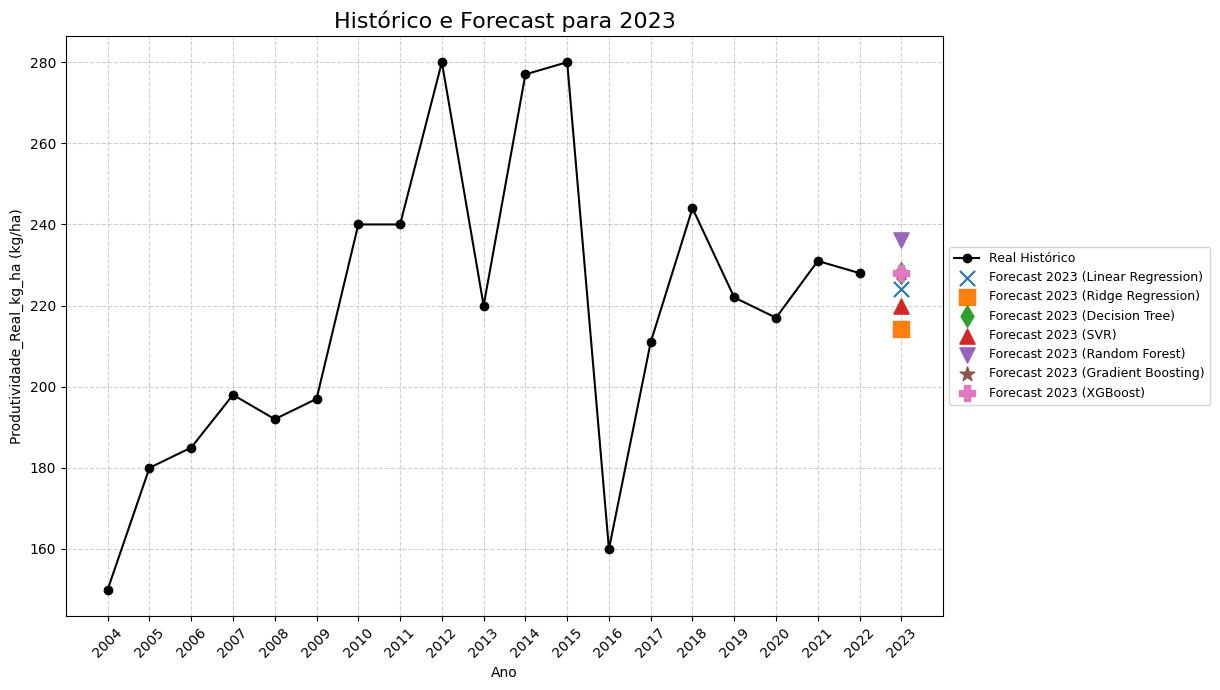

In [13]:
# CÉLULA S3.12 (OPCIONAL): PREVISÃO PARA ANOS FUTUROS (EX: 2024)

# --- Pré-requisitos ---
# df_sprint3_model_input: DataFrame final usado para treinar os modelos da Sprint 3
# features_s3_list: Lista com os nomes das colunas de features usadas
# target_s3_model: String com o nome da coluna alvo ('Produtividade_Real_kg_ha')
# models_to_train_s3: Dicionário definido na Célula S3.9 com as instâncias dos modelos
# RANDOM_STATE, N_ESTIMATORS_RF: Constantes globais

run_forecasting = True # Mude para False para pular esta célula

final_forecast_models = {}
X_future_forecast = None
forecasts_future_year = {}
YEAR_TO_FORECAST = MAX_YEAR_IBGE + 1 # Ex: 2023 se MAX_YEAR_IBGE é 2022

if run_forecasting and 'df_sprint3_model_input' in locals() and not df_sprint3_model_input.empty and \
    'features_s3_list' in locals() and features_s3_list and \
    'target_s3_model' in locals() and target_s3_model and \
    'models_to_train_s3' in locals() and models_to_train_s3 :

    print(f"\n--- PREVISÃO FUTURA PARA O ANO: {YEAR_TO_FORECAST} ---")
    print(f"\n--- 1. Retreinando modelos finais com todos os dados históricos ({df_sprint3_model_input['Ano'].min()}-{df_sprint3_model_input['Ano'].max()}) ---")
    X_full_s3 = df_sprint3_model_input[features_s3_list]
    y_full_s3 = df_sprint3_model_input[target_s3_model]

    for name, model_instance in models_to_train_s3.items():
        print(f"--- Retreinando: {name} para previsão ---")
        try:
            final_model_fc = model_instance.__class__(**model_instance.get_params())
            if 'random_state' in final_model_fc.get_params(): final_model_fc.set_params(random_state=RANDOM_STATE)
            if 'n_jobs' in final_model_fc.get_params(): final_model_fc.set_params(n_jobs=-1)
            final_model_fc.fit(X_full_s3, y_full_s3)
            final_forecast_models[name] = final_model_fc
        except Exception as e: print(f"Erro ao retreinar {name} para forecast: {e}")
    print(f"Modelos finais para forecast retreinados: {list(final_forecast_models.keys())}")

    print(f"\n--- 2. Estimando Features para {YEAR_TO_FORECAST} ---")
    try:
        last_hist_year_data = df_sprint3_model_input.iloc[-1]
        features_for_future_dict = {}
        # Lagged features
        if 'Produtividade_Real_kg_ha_lag1' in features_s3_list:
             features_for_future_dict['Produtividade_Real_kg_ha_lag1'] = last_hist_year_data['Produtividade_Real_kg_ha']
        if 'Area_Colhida_ha_Real_lag1' in features_s3_list:
             features_for_future_dict['Area_Colhida_ha_Real_lag1'] = last_hist_year_data['Area_Colhida_ha_Real']
        # Non-lagged features (EXEMPLOS - REPETIR ÚLTIMO ANO OU USAR MÉDIAS)
        non_lag_features = [f for f in features_s3_list if '_lag1' not in f]
        for col in non_lag_features:
            if col in last_hist_year_data: # Tenta repetir o último ano
                features_for_future_dict[col] = last_hist_year_data[col]
            elif col in df_sprint3_model_input.columns: # Senão, usa média histórica
                features_for_future_dict[col] = df_sprint3_model_input[col].mean()
            else: # Fallback se a coluna não existir em nenhum (improvável aqui)
                features_for_future_dict[col] = 0
            print(f"Estimativa {col} ({YEAR_TO_FORECAST}): {features_for_future_dict.get(col, 'N/A')}")

        X_future_forecast = pd.DataFrame([features_for_future_dict])[X_full_s3.columns]
        print("\nDataFrame com features estimadas para forecast criado:")
        print(X_future_forecast)
    except Exception as e: print(f"Erro ao estimar features futuras: {e}"); X_future_forecast = None

    if final_forecast_models and X_future_forecast is not None:
        print(f"\n--- 3. Gerando Previsões para {YEAR_TO_FORECAST} ---")
        for name, model in final_forecast_models.items():
            try:
                y_fc = model.predict(X_future_forecast)
                forecasts_future_year[name] = y_fc[0]
                print(f"Previsão {YEAR_TO_FORECAST} ({name}): {forecasts_future_year[name]:.2f} kg/ha")
            except Exception as e: print(f"Erro no forecast com {name}: {e}"); forecasts_future_year[name] = np.nan

        # Visualizar Histórico + Previsões Futuras
        if forecasts_future_year:
            print(f"\n--- Gerando Gráfico: Histórico + Previsões {YEAR_TO_FORECAST} ---")
            plt.figure(figsize=(15, 7))
            plt.plot(df_sprint3_model_input['Ano'], df_sprint3_model_input[target_s3_model], label='Real Histórico', marker='o', color='black')
            markers = ['x', 's', 'd', '^', 'v', '*', 'P']; marker_idx = 0
            for name, forecast_val in forecasts_future_year.items():
                if not pd.isna(forecast_val):
                     marker = markers[marker_idx % len(markers)]
                     plt.scatter([YEAR_TO_FORECAST], [forecast_val], label=f'Forecast {YEAR_TO_FORECAST} ({name})', marker=marker, s=120, zorder=10)
                     marker_idx += 1
            plt.xlabel('Ano'); plt.ylabel(f'{target_s3_model} (kg/ha)'); plt.title(f'Histórico e Forecast para {YEAR_TO_FORECAST}', fontsize=16)
            plt.legend(fontsize=9, loc='center left', bbox_to_anchor=(1, 0.5)); plt.grid(True, linestyle='--', alpha=0.6)
            all_years_for_ticks = sorted(list(df_sprint3_model_input['Ano'].unique()) + [YEAR_TO_FORECAST])
            plt.xticks(ticks=all_years_for_ticks, rotation=45)
            plt.xlim(left=df_sprint3_model_input['Ano'].min() - 1, right=YEAR_TO_FORECAST + 1)
            plt.tight_layout(rect=[0, 0, 0.82, 1]); plt.show()
else:
    print("\n--- Previsão Futura pulada: Dados ou modelos não disponíveis, ou 'run_forecasting' é False. ---")